# MIXTRAL 8x7B - Mixture of Experts

This will not run on the free T4 GPU from Google Colab. You will need A100 to run this.

### Install Required Packages

In [1]:
!pip install transformers trl accelerate torch bitsandbytes peft datasets -qU
!pip install flash-attn --no-build-isolation

ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.9 MB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: -9
  ╰─> [0 lines of output]
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [35]:
!pip install --upgrade pip transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1


#### Load HF Dataset

We need a dataset to fine-tune a model, for this example we will be using a subset of the `mosaicml/instruct-v3` dataset.

In [2]:
from datasets import load_dataset

instruct_tune_dataset = load_dataset("mosaicml/instruct-v3")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/56167 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6807 [00:00<?, ? examples/s]

#### Data structure

The dataset contains three different columns. We are only interested in the columns `prompt` and `response`. There are 9 different possible source value in the `source` column. We are only interested in one of them.

In [3]:
instruct_tune_dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'response', 'source'],
        num_rows: 56167
    })
    test: Dataset({
        features: ['prompt', 'response', 'source'],
        num_rows: 6807
    })
})

In [12]:
instruct_tune_dataset['test'][0:10]['source']

['duorc',
 'dolly_hhrlhf',
 'dolly_hhrlhf',
 'dolly_hhrlhf',
 'spider',
 'dolly_hhrlhf',
 'cot_gsm8k',
 'dolly_hhrlhf',
 'quality',
 'cot_gsm8k']

Since we want to generate a model that generates instructions - we're going to filter away all the subset datasets and only used the `dolly_hhrlhf` component!

In [13]:
instruct_tune_dataset = instruct_tune_dataset.filter(lambda x: x["source"] == "dolly_hhrlhf")

Filter:   0%|          | 0/56167 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6807 [00:00<?, ? examples/s]

In [14]:
instruct_tune_dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'response', 'source'],
        num_rows: 34333
    })
    test: Dataset({
        features: ['prompt', 'response', 'source'],
        num_rows: 4771
    })
})

We will use just a small subset of the data for this training example.





#### Create Formatted Prompt

In the following function we'll be merging our `prompt` and `response` columns by creating the following template:

```
<s>[INST] Use the provided input to create an instruction that could have been used to generate the response with an LLM.

{input} [/INST]

{response}</s>
```

In [15]:
instruct_tune_dataset["train"][0]

{'prompt': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction\nWhat are different types of grass?\n\n### Response\n',
 'response': 'There are more than 12,000 species of grass. The most common is Kentucky Bluegrass, because it grows quickly, easily, and is soft to the touch. Rygrass is shiny and bright green colored. Fescues are dark green and shiny. Bermuda grass is harder but can grow in drier soil.',
 'source': 'dolly_hhrlhf'}

In [16]:
def create_prompt(sample):
  bos_token = "<s>"
  original_system_message = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
  system_message = "[INST]Use the provided input to create an instruction that could have been used to generate the response with an LLM."
  response = sample["prompt"].replace(original_system_message, "").replace("\n\n### Instruction\n", "").replace("\n### Response\n", "").strip()
  input = sample["response"]
  eos_token = "</s>"

  full_prompt = ""
  full_prompt += bos_token
  full_prompt += system_message
  full_prompt += "\n" + input
  full_prompt += "[/INST]"
  full_prompt += response
  full_prompt += eos_token

  return full_prompt

In [18]:
print(instruct_tune_dataset["train"][0])

{'prompt': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction\nWhat are different types of grass?\n\n### Response\n', 'response': 'There are more than 12,000 species of grass. The most common is Kentucky Bluegrass, because it grows quickly, easily, and is soft to the touch. Rygrass is shiny and bright green colored. Fescues are dark green and shiny. Bermuda grass is harder but can grow in drier soil.', 'source': 'dolly_hhrlhf'}


In [20]:
create_prompt(instruct_tune_dataset["train"][0])

'<s>[INST]Use the provided input to create an instruction that could have been used to generate the response with an LLM.\nThere are more than 12,000 species of grass. The most common is Kentucky Bluegrass, because it grows quickly, easily, and is soft to the touch. Rygrass is shiny and bright green colored. Fescues are dark green and shiny. Bermuda grass is harder but can grow in drier soil.[/INST]What are different types of grass?</s>'

### Map the Dataset

In [ ]:
# mapped_data = instruct_tune_dataset.map(create_prompt)

### Loading the Base Model

Load the model in `4bit`, with double quantization, with `bfloat16` as the compute dtype.

In this case we are using the instruct-tuned model - instead of the base model. For fine-tuning a base model will need a lot more data!

In [36]:
model_id = "mistralai/Mixtral-8x7B-v0.1"

In [37]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

In [38]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map='auto',
    quantization_config=nf4_config,
    use_cache=False,
    attn_implementation="flash_attention_2"

)

KeyError: 'mixtral'

In [26]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Let's example how well the model does at this task currently:

In [13]:
def generate_response(prompt, model):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to('cuda')

  generated_ids = model.generate(**model_inputs,
                                 max_new_tokens=512,
                                 do_sample=True,
                                 pad_token_id=tokenizer.eos_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0].replace(prompt, "")

In [ ]:
prompt="""[INST]Use the provided input to create an instruction that could have been used to generate the response with an LLM. \nThere are more than 12,000 species of grass. The most common is Kentucky Bluegrass, because it grows quickly, easily, and is soft to the touch. Rygrass is shiny and bright green colored. Fescues are dark green and shiny. Bermuda grass is harder but can grow in drier soil.[\INST]"""

generate_response(prompt, model)

### Tokenization

In [15]:
def tokenize_prompts(prompt):
    return tokenizer(create_prompt(prompt))

tokenized_train_dataset = instruct_tune_dataset["train"].map(tokenize_prompts)
tokenized_val_dataset = instruct_tune_dataset["test"].map(tokenize_prompts)

Map:   0%|          | 0/34333 [00:00<?, ? examples/s]

Map:   0%|          | 0/4771 [00:00<?, ? examples/s]

39104


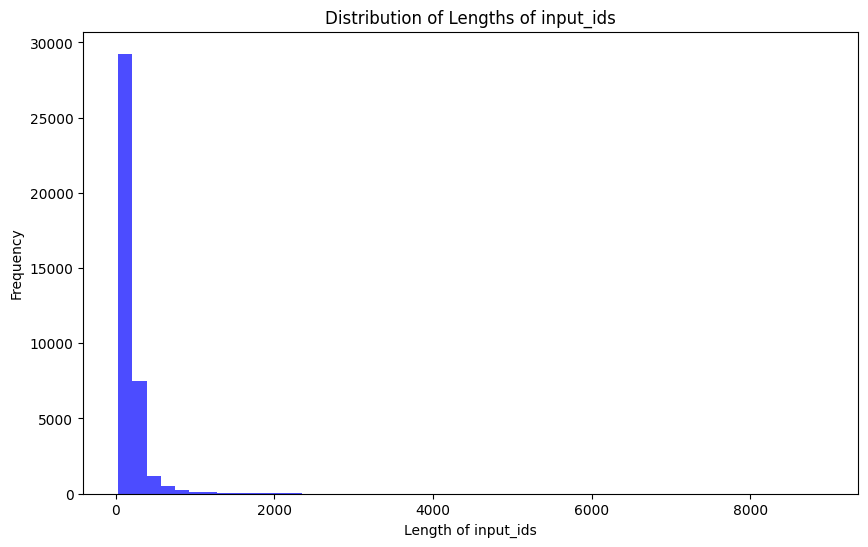

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    # plt.xlim([0, 1500])
    plt.show()


plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

39104


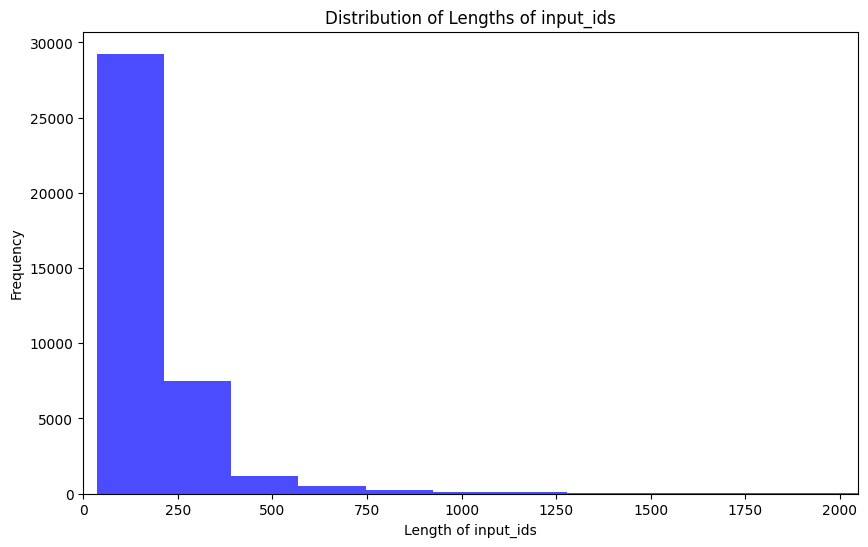

In [ ]:
def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.xlim([0, 2048])
    plt.show()


plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [16]:
print(model)

MixtralForCausalLM(
  (model): MixtralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MixtralDecoderLayer(
        (self_attn): MixtralFlashAttention2(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MixtralRotaryEmbedding()
        )
        (block_sparse_moe): MixtralSparseMoeBlock(
          (gate): Linear4bit(in_features=4096, out_features=8, bias=False)
          (experts): ModuleList(
            (0-7): 8 x MixtralBlockSparseTop2MLP(
              (w1): Linear4bit(in_features=4096, out_features=14336, bias=False)
              (w2): Linear4bit(in_features=14336, out_features=4096, bias=False)
              (w3): Linear4bit(in_features=4096, ou

### Setting up the Training
we will be using the `huggingface` and the `peft` library!

In [17]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
        target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    task_type="CAUSAL_LM"
)

we need to prepare the model to be trained in 4bit so we will use the  `prepare_model_for_kbit_training` function from peft

> Indented block



In [18]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

In [19]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [20]:
print_trainable_parameters(model)

trainable params: 56836096 || all params: 23539437568 || trainable%: 0.24145052674182907


In [21]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MixtralForCausalLM(
      (model): MixtralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MixtralDecoderLayer(
            (self_attn): MixtralFlashAttention2(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer)

### Hyper-paramters for training
These parameters will depend on how long you want to run training for.
Most important to consider:

`num_train_epochs/max_steps`: How many iterations over the data you want to do, BE CAREFUL, don't try too many, you will over-fit!!!!!

`learning_rate`: Controls the speed of convergence


In [22]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    print(torch.cuda.device_count())
    model.is_parallelizable = True
    model.model_parallel = True

In [23]:
from transformers import TrainingArguments

args = TrainingArguments(
  output_dir = "Mixtral_Alpace_v2",
  #num_train_epochs=5,
  max_steps = 1000, # comment out this line if you want to train in epochs
  per_device_train_batch_size = 32,
  warmup_steps = 0.03,
  logging_steps=10,
  save_strategy="epoch",
  #evaluation_strategy="epoch",
  evaluation_strategy="steps",
  eval_steps=10, # comment out this line if you want to evaluate at the end of each epoch
  learning_rate=2.5e-5,
  bf16=True,
  # lr_scheduler_type='constant',
)

Setting up the trainer.

`max_seq_length`: Context window size


In [24]:
from trl import SFTTrainer

max_seq_length = 1024

trainer = SFTTrainer(
  model=model,
  peft_config=peft_config,
  max_seq_length=max_seq_length,
  tokenizer=tokenizer,
  packing=True,
  formatting_func=create_prompt, # this will aplly the create_prompt mapping to all training and test dataset
  args=args,
  train_dataset=instruct_tune_dataset["train"],
  eval_dataset=instruct_tune_dataset["test"]
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:341: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Step,Training Loss,Validation Loss
10,1.799700,1.913130


In [ ]:
trainer.save_model("Mixtral_Alpace_v2")

# Save Model and Push to Hub

In [ ]:
# !pip install huggingface-hub -qU

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

In [ ]:
# trainer.push_to_hub("Promptengineering/mistral-instruct-generation")

In [ ]:
merged_model = model.merge_and_unload()

In [ ]:
def generate_response(prompt, model):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to('cuda')

  generated_ids = model.generate(**model_inputs,
                                 max_new_tokens=150,
                                 do_sample=True,
                                 pad_token_id=tokenizer.eos_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0]

In [ ]:
prompt = "[INST]Use the provided input to create an instruction that could have been used to generate the response with an LLM.\nThere are more than 12,000 species of grass. The most common is Kentucky Bluegrass, because it grows quickly, easily, and is soft to the touch. Rygrass is shiny and bright green colored. Fescues are dark green and shiny. Bermuda grass is harder but can grow in drier soil.[/INST]"


In [ ]:
generate_response(prompt, merged_model)

In [ ]:
250*32

8000